## Time spent
- 12/7: 1:45

## Outline

- Directed Graph
- Directed Graph: Ordered
- Directed Graph: Ordered, Competitive

Methods
- Build nodes
- Add edges according to rules
- Calculate component sizes

# To-do
- Implement DER
- Implement ODER, C-ODER
- Visualization..?
- Calculate component sizes of a graph with Tarjan algorithm
- Plot of largest SCC

Go though C++ tutorials linked to in Glotzdocs.

Speed up options:
- Multiprocessing and pool
- Cython

In [1]:
# Import needed packages
import time
import itertools
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# not yet installed
import networkx as nx
import percolate

In [3]:
# For cleanliness, ignore warnings after first appearance. 
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [ ]:
from sem_graphs import gnp_random_graph

# 00 - Percolation implementations (simple)

### Network science background
- Erdos-Renyi graphs (random, non-directed graphs): [link here](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)
- Directed Erdos-Renyi graphs, DER (directed edges)
- Paper covers two models:
  - Ordered, directed Erdos-Renyis (ODER)
  - Competitive ODER
  
I'm currently using Networkx to play around with these. In the generator source code [here](https://github.com/networkx/networkx/blob/1174e443263f8a60dc82083ad1c563a4c25e5582/networkx/generators/random_graphs.py), `erdos_renyi_graph` is just an alias for `gnp_random_graph`.

Algorithm for ODER:
- begin with a set of $n$ isolated nodes on which we have placed an arbitrarry ordering from 1 to $n$
- at each step, add a single directed edge between two nodes selected uniformly at random
    - the head of the directed edge = node higher in ordering
    - ...UNLESS the edge already exists in the graph
- repeat steps until $m$ edges have been added (edges and reverse edges count as separate edges)

In [4]:
def check_if_edge_exists(proposed,edges):
    for item in edges:
        if proposed==item: return True
        else: pass

In [5]:
# ODER implementation
def ODER(n,m):
    # set up list nodes with ranked order
    n_list = np.linspace(0,n-1,n).astype(int)

    # add m edges to the plot
    edge_list = []
    while len(edge_list)<m:
        first_node, second_node = random.sample(list(n_list),2)
        proposed_edge = tuple(sorted((first_node,second_node)))
        if check_if_edge_exists(proposed_edge,edge_list):
            if check_if_edge_exists(tuple(reversed(proposed_edge)),edge_list): pass
            else: edge_list.append(tuple(reversed(proposed_edge)))
        else: edge_list.append(proposed_edge)
    return edge_list

In [52]:
# C-ODER implementation
def CODER(n,m):
    # set up list nodes with ranked order
    n_list = np.linspace(0,n-1,n).astype(int)
    
    # add m edges to the plot
    edge_list = []
    while len(edge_list)<m:
        if len(edge_list)%(m/10)==0: print(len(edge_list))
        # samples without replacement (no duplicates)
        first_node, second_node, third_node = random.sample(list(n_list),3)
        proposed_edges = tuple(itertools.combinations(tuple(sorted((first_node,second_node,third_node))), 2))
        
        # for nodes with min difference, check if they/their reverse already exist; if no, add them
        difference = np.asarray([nodes[1]-nodes[0] for nodes in proposed_edges])
        idx = np.where(difference == difference.min())[0]
        for i in idx:
            proposed_edge = proposed_edges[i]
            # avoid duplicates; adds in reverse edges
            if check_if_edge_exists(proposed_edge,edge_list): pass
#                 if check_if_edge_exists(tuple(reversed(proposed_edge)),edge_list): pass
#                 else: edge_list.append(tuple(reversed(proposed_edge)))
            else: edge_list.append(proposed_edge)
    return edge_list    

In [ ]:
edge_density = 50
n = 10**2
m = edge_density*n
print('Edge density: %s \nNumber of nodes: %s \nNumber of edges: %s' %(edge_density,n,m))
oder_test = ODER(n,m)

In [53]:
'''
C-ODER is much slower than ODER because it has to do more iterations
Effectively, it's like having a lower MC probability
'''

edge_density = 50
n = 5**2
m = edge_density*n
print('Edge density: %s \nNumber of nodes: %s \nNumber of edges: %s' %(edge_density,n,m))
coder_test = CODER(n,m)

Edge density: 50 
Number of nodes: 25 
Number of edges: 1250
125.0
125.0


KeyboardInterrupt: 

In [42]:
# Erdos Renyi from networkx as a point of comparison
# the acceptance probabiliy here is equivalent to the edge density
# Networkx generates a list of the n(n-1) possible edges
n = 10**2
p = 0.5
er = nx.erdos_renyi_graph(n,p,directed=True)
# print(er.nodes())
# print(er.edges())

### Problem: This is going to take a lot of compute power

Running for $10^3$ nodes is arlready overwhelming my computational power. The paper runs on $10^6$ nodes, so I have a lot of optimization to do... 

## Visualization
Yes, I can see if I can adapt networkx's draw capabilities.

I can also just make a covariance-like binary imshow to show what is connected to what.

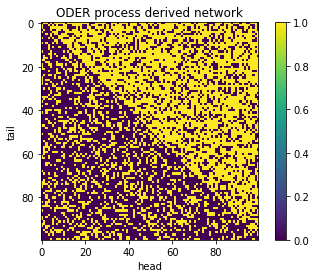

0.5


In [44]:
# for now, just do a quick "is there an edge there" proof of concept
viz_array = np.zeros((n,n))
for i in oder_test:
    viz_array[i[0],i[1]]+=1

plt.imshow(viz_array)
plt.title('ODER process derived network')
plt.ylabel('tail')
plt.xlabel('head')
plt.colorbar()
plt.show()

print(np.sum(viz_array)/n**2)

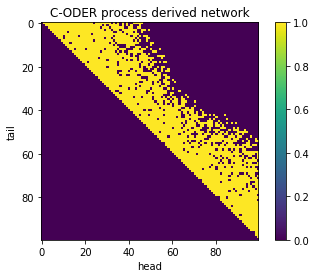

0.25


In [45]:
# for now, just do a quick "is there an edge there" proof of concept
viz_array = np.zeros((n,n))
for i in coder_test:
    viz_array[i[0],i[1]]+=1

plt.imshow(viz_array)
plt.title('C-ODER process derived network')
plt.ylabel('tail')
plt.xlabel('head')
plt.colorbar()
plt.show()

print(np.sum(viz_array)/n**2)

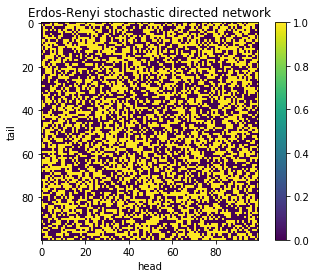

0.5026


In [43]:
# for now, just do a quick "is there an edge there" proof of concept
viz_array = np.zeros((n,n))
for i in er.edges():
    viz_array[i[0],i[1]]+=1

plt.imshow(viz_array)
plt.title('Erdos-Renyi stochastic directed network')
plt.ylabel('tail')
plt.xlabel('head')
plt.colorbar()
plt.show()

print(np.sum(viz_array)/n**2)

### Next up: Clustering algorithm implemented in paper

SCC is different from a cluster. Need to detail that here.

Implementation of Tarjan algorithm. Python source [here](https://github.com/bwesterb/py-tarjan).

Pseudocode given in the wikipedia article [here](https://en.wikipedia.org/wiki/Tarjan%27s_strongly_connected_components_algorithm).

Gives $O(E\log{E})$ clustering performance when using the pseudocode in section 5.

In [ ]:
# Implementation of clustering algorithm from the paper

# Tarjan's algorithm
Playing around with an implementation from here: http://www.geeksforgeeks.org/tarjan-algorithm-find-strongly-connected-components/

This is honestly kinda like Hoshen Kopelman algorithm, but for networks

Notes:
- In the below, nodes are called "vertices"

Questions:
- What is the DFS transversal?

Figure source: [here](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-042j-mathematics-for-computer-science-fall-2010/readings/MIT6_042JF10_chap06.pdf)

![graphexample](figs/tail_head.png)

In [ ]:
# Python program to find strongly connected components in a given
# directed graph using Tarjan's algorithm (single DFS)
#Complexity : O(V+E)
  
from collections import defaultdict
  
#This class represents an directed graph 
# using adjacency list representation
class Graph:
  
    def __init__(self,vertices):
        #No. of vertices = nodes
        self.V= vertices 
         
        # default dictionary to store graph
        self.graph = defaultdict(list) 
         
        self.Time = 0
  
    # function to add an edge to graph
    def addEdge(self,u,v):
        # to key value u (tail), adds value v (head)
        self.graph[u].append(v)
         
  
    '''A recursive function that find finds and prints strongly connected
    components using DFS traversal
    u --> The vertex to be visited next
    disc[] --> Stores discovery times of visited vertices
    low[] -- >> earliest visited vertex (the vertex with minimum
                discovery time) that can be reached from subtree
                rooted with current vertex
    st -- >> To store all the connected ancestors (could be part
           of SCC)
    stackMember[] --> bit/index array for faster check whether
                  a node is in stack
    '''
    def SCCUtil(self,u, low, disc, stackMember, st):

        # "u" is the vertex that the SCC method is searching for
 
        # Initialize discovery time and low value
        disc[u] = self.Time
        low[u] = self.Time
        # self.Time is a way of tracking the steps you've taken. that's why this is adding here
        self.Time += 1
        # saying that this vertex is now a number of the stack
        stackMember[u] = True
        # this actually tracks who is in what stack-- starting with u
        st.append(u)
 
        # Go through all vertices adjacent to this
        # for all vertices stored as heads under the dictionary key u...
        for v in self.graph[u]:
             
            # If v is not visited yet, then recur for it
            if disc[v] == -1 :
             
                self.SCCUtil(v, low, disc, stackMember, st)
 
                # Check if the subtree rooted with v has a connection to
                # one of the ancestors of u
                # Case 1 (per above discussion on Disc and Low value)
                low[u] = min(low[u], low[v])
                         
            elif stackMember[v] == True: 
 
                '''Update low value of 'u' only if 'v' is still in stack
                (i.e. it's a back edge, not cross edge).
                Case 2 (per above discussion on Disc and Low value) '''
                low[u] = min(low[u], disc[v])
 
        # head node found, pop the stack and print an SCC
        w = -1 #To store stack extracted vertices
        if low[u] == disc[u]:
            while w != u:
                w = st.pop()
                print(w)
                stackMember[w] = False            
     
 
    #The function to do DFS traversal. 
    # It uses recursive SCCUtil()
    def SCC(self):
  
        # Mark all the vertices as not visited 
        # and Initialize parent and visited, 
        # and ap(articulation point) arrays
        # makes this into a lenght 7 array of -1
        disc = [-1] * (self.V)
        low = [-1] * (self.V)
        stackMember = [False] * (self.V)
        st =[]
         
 
        # Call the recursive helper function 
        # to find articulation points
        # in DFS tree rooted with vertex 'i'
        # for each vertex
        for i in range(self.V):
            # if the vertex has not been visited
            if disc[i] == -1:
                # run the SCCUtil for that vertex
                self.SCCUtil(i, low, disc, stackMember, st)

                
g3 = Graph(7)
# This is adding in edges very differently from how I'm approaching it
g3.addEdge(0, 1)
g3.addEdge(1, 2)
g3.addEdge(2, 0)
g3.addEdge(1, 3)
g3.addEdge(1, 4)
g3.addEdge(1, 6)
g3.addEdge(3, 5)
g3.addEdge(4, 5)
print("nSSC in third graph")
print(g3.V)
print(list(g3.graph.items()))
g3.SCC()

#This code is contributed by Neelam Yadav

## Playing around with networkx capabilities

So, looks like this is not so straightforward.

Networkx works from different graph classes, e.g. [here](https://github.com/networkx/networkx/blob/a660d5728b3b3463b08c03ab8138f62468487c71/networkx/classes/digraph.py).

Class documentation is here: https://docs.python.org/3/tutorial/classes.html

Read through this: http://www.souravsengupta.com/cds2015/python/LPTHW.pdf

Unit tests: http://docs.python-guide.org/en/latest/writing/tests/

In [21]:
# Trying to use networkx
'''
n: number of nodes
p: probability of an edge being accepted
'''

def gnp_random_graph(n, p):
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return complete_graph(n, create_using=G)

    # Itertools makes all possible edge permutations between nodes-- so size of edges is n(n-1)-- I think
    edges = list(itertools.permutations(range(n), 2))

    # Here is where I need to add competition/ 
    for e in edges:
        if random.random()< p:
            G.add_edge(e)
    return G

In [33]:
er = nx.erdos_renyi_graph(10,.5,directed=True)
print(er.nodes())
print(er.edges())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[(0, 9), (0, 3), (0, 4), (0, 5), (0, 6), (1, 9), (1, 3), (1, 7), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 7), (3, 0), (3, 2), (3, 4), (3, 5), (4, 0), (4, 8), (4, 5), (4, 6), (5, 0), (5, 8), (5, 2), (5, 9), (5, 7), (6, 1), (6, 2), (6, 3), (6, 4), (6, 7), (6, 8), (7, 1), (7, 3), (7, 4), (7, 9), (8, 9), (8, 2), (8, 4), (8, 5), (8, 6), (9, 1), (9, 4), (9, 7)]


In [ ]:
# ER example here (done with networkx)
# Based on this, will take about 500 seconds to make a graph with 10e6 nodes
# Can definitely parallelize this with map/pool!
# Reference: http://chriskiehl.com/article/parallelism-in-one-line/ < this is python 2.7
# Good reference on python 3: https://www.ploggingdev.com/2017/01/multiprocessing-and-multithreading-in-python-3/

n = [5000]
timed = []
for N in n:
    start = time.time()
    gnp_random_graph(int(N),0.5)
    timed.append(time.time()-start)
    start = time.time()
#     er = nx.erdos_renyi_graph(int(N),.5)
    er = nx.erdos_renyi_graph(int(N),.5)
    timed.append(time.time()-start)
    
print(timed)
    
# plt.scatter(n,timed)
# plt.subplot(121)
# nx.draw(er, with_labels=True, font_weight='bold')
# plt.subplot(122)
# nx.draw_shell(er, with_labels=True, font_weight='bold')

In [ ]:
# DER example here
er = nx.erdos_renyi_graph(10,.5,directed=True)
plt.subplot(121)
nx.draw(er, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw_shell(er, with_labels=True, font_weight='bold')

### Model 1: Ordered, Directed Erdos-Renyi (ODER)
- Generalization of the directed ER model to ordered graph
- Form two large components, which explosively merge (discontinuous jump in the size of the largest strongly connected component)

Ordered, directed graphs can be made using the OrderedDiGraph class, source [here](https://github.com/networkx/networkx/blob/386b71a7af6c4898331f62987d8ced3f5621b680/networkx/classes/ordered.py).

From the python `collections` documentation [here](https://docs.python.org/3/library/collections.html#collections.OrderedDict): "an OrderedDict is a dict that remembers the order that keys were first inserted. If a new entry overwrites an existing entry, the original insertion position is left unchanged. Deleting an entry and reinserting it will move it to the end."

In [ ]:
# ODER example here

### Model 2: Competitive ODER
- Adds competition: preference for connecting nodes of similar rank
- See similar discontinuous jump in cluster size, but "more explosive"
- Get an effective phase separation of the two large components: one containing the lower-ranked users, one containing the higher-ranked users
- TAKEAWAY: Some bias towards grouping similar-ranked nodes leads to formation of two distinct groups of nodes (classes) with little flow of information between the classes

In [ ]:
# CODER example here

# 01 - Clustering implementations

### Classical non-directed NZ clustering algorithm

In [ ]:
# Newmann-Ziff implementation on ER

# 02 - Thermodynamics

In [ ]:
# Plot SCC ("strongly connected component") versus edge density, per paper

In [ ]:
# Find critical exponents-- they actually don't have them

# 03 - Something else interesting?
- Can we say something else interesting from this work that the authors might not have thought about?
- What could have made this paper more interesting?
- How innovative actually is this?